In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
import torch.nn as nn
import time
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
import random
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as F
#!pip install torchvision

In [ ]:
# load brain_extraction data
X_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/X_Guys.npy')
y_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/y_Guys.npy')
ids_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/ids_Guys.npy')
X_HH = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/X_HH.npy')
y_HH = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/y_HH.npy')
ids_HH = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/ids_HH.npy')
X_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/X_IOP.npy')
y_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/y_IOP.npy')
ids_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/brain_extraction/ids_IOP.npy')

In [ ]:
#center data
def centring(X):
    X=np.asarray(X)
    epsilon = 1e-7 
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    centered_array = (X - mean) / (std+epsilon)
    return centered_array

X_Guys_centered=centring(X_Guys)
X_HH_centered=centring(X_HH)
X_IOP_centered=centring(X_IOP)

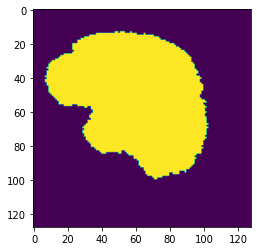

(128, 128)


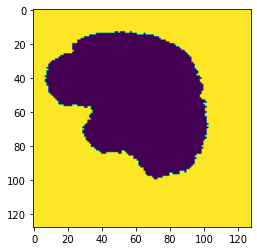

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
def to_one_hot_binary_matrix_batch(batch_matrix):
    batch_matrix = np.array(batch_matrix, dtype='int')
    one_hot = np.zeros((batch_matrix.shape[0], 2, batch_matrix.shape[1], batch_matrix.shape[2]), dtype=float)
    one_hot[:, 0] = batch_matrix == 0
    one_hot[:, 1] = batch_matrix == 1
    
    return one_hot

plt.imshow(y_HH[0][0])
plt.show()
print(y_HH[0][0].shape)
encoded = to_one_hot_binary_matrix_batch((y_HH[0]))
plt.imshow(encoded[0][0])
plt.show()

plt.show()
print(y_HH[0][1])

In [ ]:
# producing required train / val / test split
print("initial shapes")
print(X_Guys.shape)
print(y_Guys.shape)
print(ids_Guys.shape)
print(X_HH.shape)
print(y_HH.shape)
print(ids_HH.shape)
print(X_IOP.shape)
print(y_IOP.shape)
print(ids_IOP.shape)

combined_Guys_HH_X = np.concatenate([X_Guys_centered, X_HH_centered], axis=0)
combined_Guys_HH_y = np.concatenate([y_Guys, y_HH], axis=0)

X_train = torch.Tensor(combined_Guys_HH_X[0:int(len(combined_Guys_HH_X)*0.85)])
y_train = torch.Tensor(combined_Guys_HH_y[0:int(len(combined_Guys_HH_y)*0.85)])

# val data 15%
X_val = torch.Tensor(combined_Guys_HH_X[int(len(combined_Guys_HH_X)*0.85):int(len(combined_Guys_HH_X))])
y_val = torch.Tensor(combined_Guys_HH_y[int(len(combined_Guys_HH_y)*0.85):int(len(combined_Guys_HH_y))])
#test data from IOP data
X_test =  torch.Tensor(X_IOP_centered[0:int(len(X_IOP_centered))])
y_test = torch.Tensor(y_IOP[0:int(len(y_IOP))])

print("Check after split")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

initial shapes
(317, 40, 128, 128)
(317, 40, 128, 128)
(317,)
(176, 40, 128, 128)
(176, 40, 128, 128)
(176,)
(71, 40, 128, 128)
(71, 40, 128, 128)
(71,)
Check after split
torch.Size([419, 40, 128, 128])
torch.Size([419, 40, 128, 128])
torch.Size([74, 40, 128, 128])
torch.Size([74, 40, 128, 128])
torch.Size([71, 40, 128, 128])
torch.Size([71, 40, 128, 128])


In [ ]:
# slice data into 2D
def reslice(x, split_size):
  temp = torch.split(x,split_size,dim=1)
  output=[]
  for i in range(len(temp)):
    output.append(temp[i])
  output=torch.cat(output, dim=0)
  return output

#X_train=reslice(X_train,1)
#y_train=reslice(y_train,1)
#X_val=reslice(X_val,1)
#y_val=reslice(y_val,1)
#X_test=reslice(X_test,1)
#y_test=reslice(y_test,1)

#sample slices - just pick 1 slice from 40 so for training always 
X_train=X_train[:,10,:,:]
X_val=X_val[:,20,:,:]
X_test=X_test[:,30,:,:]
y_train=y_train[:,10,:,:]
y_val=y_val[:,20,:,:]
y_test=y_test[:,30,:,:]

#introduce channel
X_train=torch.reshape(X_train,(len(X_train),1,128,128))
X_val=torch.reshape(X_val,(len(X_val),1,128,128))
X_test=torch.reshape(X_test,(len(X_test),1,128,128))


print("Check shapes after slicing into 2D")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


Check shapes after slicing into 2D
torch.Size([419, 1, 128, 128])
torch.Size([419, 128, 128])
torch.Size([74, 1, 128, 128])
torch.Size([74, 128, 128])
torch.Size([71, 1, 128, 128])
torch.Size([71, 128, 128])


(419, 2, 128, 128)
(74, 2, 128, 128)
(71, 2, 128, 128)


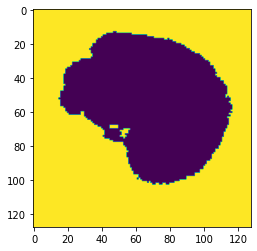

In [ ]:
y_train = to_one_hot_binary_matrix_batch(y_train)
y_val= to_one_hot_binary_matrix_batch(y_val)
y_test = to_one_hot_binary_matrix_batch(y_test)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
plt.imshow(y_test[0][0])

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable

def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1.0):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        input = F.sigmoid(input)

        tp = (input * target).sum()
        fp = ((1 - target) * input).sum()
        fn = (target * (1 - input)).sum()

        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        loss = 1 - tversky

        return loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.alpha).exp() * loss

        return loss.mean()

def lovasz_softmax_flat(logits, labels):
    probas = F.softmax(logits, dim=1)
    labels = labels.float()

    if probas.numel() == 0:
        return logits * 0.0

    signs = 2 * labels - 1
    errors = (1 - probas * signs)
    errors_sorted, perm = torch.sort(errors.reshape(-1), dim=0, descending=True)
    perm = perm.cpu().numpy()
    gt_sorted = labels.reshape(-1)[perm]
    grad = lovasz_grad(gt_sorted)

    loss = torch.dot(F.elu(errors_sorted) + 1, Variable(grad, requires_grad=False))
    return loss

def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.cumsum(0)
    union = gts + (1 - gt_sorted).cumsum(0)
    jaccard = 1.0 - intersection / union
    if p > 1: 
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SegNet, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes


        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        self.conv10 = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x, pool1_indices = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x, pool2_indices = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x, pool3_indices = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x, pool4_indices = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x, pool5_indices = self.pool(x)
        x = self.unpool(x, pool5_indices)
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.unpool(x, pool4_indices)
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.unpool(x, pool3_indices)
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.unpool(x, pool2_indices)
        x = F.relu(self.bn9(self.conv9(x)))
        x = self.conv10(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return torch.sigmoid(x)


class FCN_flexible(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=5):
        super(FCN_flexible, self).__init__()
        encoder_layers = []
        in_channels = input_shape[0]
        for i in range(num_layers):
            out_channels = 64 * (2 ** i)
            encoder_layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*encoder_layers)
        self.middle = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        )
        decoder_layers = []
        for i in range(num_layers - 1, -1, -1):
            out_channels = 64 * (2 ** i)
            decoder_layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob)
            ])
            in_channels = out_channels

        decoder_layers.extend([
            nn.Conv2d(out_channels, num_classes, kernel_size=1),
            nn.Sigmoid()
        ])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = conv_block(in_channels, out_channels)

    def forward(self, x):
        return self.conv(self.pool(x))

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = conv_block(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((skip, x), dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.init_conv = conv_block(in_channels, 64)
        self.encoders = nn.ModuleList([
            Encoder(64, 128),
            Encoder(128, 256),
            Encoder(256, 512),
            Encoder(512, 1024)
        ])
        self.decoders = nn.ModuleList([
            Decoder(1024, 512),
            Decoder(512, 256),
            Decoder(256, 128),
            Decoder(128, 64)
        ])
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.init_conv(x)
        skips = [x1]
        for encoder in self.encoders:
            skips.append(encoder(skips[-1]))

        x = skips.pop()
        for decoder in self.decoders:
            x = decoder(x, skips.pop())

        return self.final_conv(x)


In [ ]:
# train functions adapted from Kaggle
def train_loop(model, loader, loss_func,optimizer):
    model.train()
    train_losses = []
    train_dices = []
    
    for i, (image, mask) in enumerate(loader):
        image = image.to(device).float()
        mask = mask.to(device).float()
        outputs = model(image)
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return train_dices, train_losses

def eval_loop(model, loader, loss_func, scheduler,training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device).float()
            mask = mask.to(device).float()
    
            outputs = model(image)
            loss = loss_func(outputs, mask)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            
            val_loss += loss
            val_dice += dice
        
        val_mean_dice = val_dice / len(loader)
        val_mean_loss = val_loss / step
        
        if training:
            scheduler.step(val_mean_dice)
        
    return val_mean_dice, val_mean_loss

def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []
    
    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func,optimizer)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func,scheduler)
        
        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss.cpu().numpy())
        val_dice_history.append(val_mean_dice)
        
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                 train_mean_loss,
                                                                                                                 val_mean_loss,
                                                                                                                 train_mean_dice,
                                                                                                                 val_mean_dice))
        

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

In [ ]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Training DICE Score', lw=3)
    plt.plot(x, val_dice_history, label='Validation DICE Score', lw=3)

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE score", fontsize=15)

    path='/content/drive/MyDrive/dhl_exam/figures/'+str(model_name)+"-dice.png"
    plt.savefig(path)
    plt.show()
    

def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Training Loss', lw=3)
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3)

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    path='/content/drive/MyDrive/dhl_exam/figures/'+str(model_name)+"-loss.png"
    plt.savefig(path)
    plt.show()
    

def prediction_dice(net, test_dataloader):
    test_dice=0

    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device).float()
          target = target.to(device).float()
           
          pred = net(data)
          out_cut = np.copy(pred.data.cpu().numpy())
          out_cut[np.nonzero(out_cut < 0.5)] = 0.0
          out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
          dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
          test_dice += dice
        mean_dice = test_dice / len(test_dataloader)
        return mean_dice

def predict(net, test_dataloader):
    test_dice=0

    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device).float()
          target = target.to(device).float()
           
          pred = net(data)
    return data.data.cpu().numpy(),target.data.cpu().numpy(),pred.data.cpu().numpy()

# training function with early stopping
def train_model_early_stopping(train_loader, val_loader, loss_func,optimizer, scheduler, num_epochs, patience=5):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    best_val_dice = 0
    consecutive_no_improvement = 0
    
    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func, optimizer)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func,scheduler)
        
        train_loss_history.append(train_mean_loss)
        train_dice_history.append(train_mean_dice)
        val_loss_history.append(val_mean_loss.cpu().numpy())
        val_dice_history.append(val_mean_dice)
        
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                 train_mean_loss,
                                                                                                                 val_mean_loss,
                                                                                                                 train_mean_dice,
                                                                                                                 val_mean_dice))
        
        # Check for improvement in validation dice coefficient
        if val_mean_dice > best_val_dice:
            best_val_dice = val_mean_dice
            consecutive_no_improvement = 0
            print('Best validation dice coefficient improved to {:.3f}'.format(best_val_dice))
        else:
            consecutive_no_improvement += 1
            print('No improvement in validation dice coefficient for {} consecutive epochs'.format(consecutive_no_improvement))
            if consecutive_no_improvement >= patience:
                print('Early stopping triggered after {} epochs'.format(epoch+1))
                break

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history,epoch+1

class numpy_dataset(Dataset): 
    def __init__(self, data, target, prob=0.3): 
        self.data =  torch.from_numpy(data)
        self.target = torch.from_numpy(target)
        self.prob=prob

    def __getitem__(self, index):
        
        
        if random.random() < self.prob:
          #transform= transforms.ColorJitter(contrast=1.5)
          transform = transforms.RandomHorizontalFlip()
          x = transform(self.data[index])
          y = transform(self.target[index][])
          if random.random() < self.prob:
            x = transforms.RandomHorizontalFlip(p=1)(x)
            y = transforms.RandomHorizontalFlip(p=1)(y)
        
        #
        if random.random() < self.prob:
            x = transforms.RandomVerticalFlip(p=1)(x)
            y = transforms.RandomVerticalFlip(p=1)(y)
        
        else:
          x=self.data[index]
          y=self.target[index]
      
        return x, y

In [ ]:

X_train=np.asarray(X_train)
X_val=np.asarray(X_val)
X_test=np.asarray(X_test)
y_train=np.asarray(y_train)
y_val=np.asarray(y_val)
y_test=np.asarray(y_test)


class numpy_dataset(Dataset): 
    def __init__(self, data, target, prob=0.5): 
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)
        self.prob = prob

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if random.random() < 0.3:
          x = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))(x)
        elif random.random() < 0.1:
          x = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)(x)
        
        if random.random() < 0.3:
            x = transforms.RandomHorizontalFlip(p=1)(x)
            y = transforms.RandomHorizontalFlip(p=1)(y)
        
        if random.random() < 0.3:
            x = transforms.RandomVerticalFlip(p=1)(x)
            y = transforms.RandomVerticalFlip(p=1)(y)

        

        return x, y



    def __len__(self):
        return len(self.data)
    
train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)
test_dataset = numpy_dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)


In [ ]:
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes=2, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
start_time = time.time()
train_loss_history, train_dice_history, val_loss_history, val_dice_history,e = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)
end_time = time.time()

Epoch: 1/50 |  Train Loss: 0.744, Val Loss: 1.666, Train DICE: 0.821, Val DICE: 0.755
Best validation dice coefficient improved to 0.755
Epoch: 2/50 |  Train Loss: 0.373, Val Loss: 0.563, Train DICE: 0.946, Val DICE: 0.931
Best validation dice coefficient improved to 0.931
Epoch: 3/50 |  Train Loss: 0.221, Val Loss: 0.340, Train DICE: 0.967, Val DICE: 0.949
Best validation dice coefficient improved to 0.949
Epoch: 4/50 |  Train Loss: 0.166, Val Loss: 0.352, Train DICE: 0.971, Val DICE: 0.945
No improvement in validation dice coefficient for 1 consecutive epochs
Epoch: 5/50 |  Train Loss: 0.128, Val Loss: 0.292, Train DICE: 0.976, Val DICE: 0.952
Best validation dice coefficient improved to 0.952
Epoch: 6/50 |  Train Loss: 0.117, Val Loss: 0.311, Train DICE: 0.976, Val DICE: 0.945
No improvement in validation dice coefficient for 1 consecutive epochs
Epoch: 7/50 |  Train Loss: 0.113, Val Loss: 0.318, Train DICE: 0.976, Val DICE: 0.939
No improvement in validation dice coefficient for 2 

In [ ]:
prediction_dice(model,test_dataloader)

0.9405348774120478

In [ ]:
# save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/dhl_exam/models/best_mix.pth')

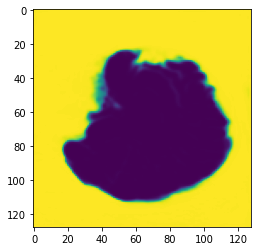

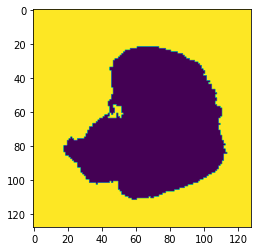

In [ ]:
prediction_dice(model, test_dataloader)
input, label,pred =predict(model,test_dataloader)
plt.imshow(pred[0][0])
plt.show()
plt.imshow(label[0][0])
plt.show()

In [ ]:
X_train=np.asarray(X_train)
X_val=np.asarray(X_val)
X_test=np.asarray(X_test)


class numpy_dataset(Dataset): 
    def __init__(self, data, target, prob=0.2): 
        self.data =  torch.from_numpy(data)
        self.target = torch.from_numpy(target)
        self.prob=prob

    def __getitem__(self, index):
       
          x=self.data[index]
          y=self.target[index]
      
          return x, y

    def __len__(self):
        return len(self.data)
    

test_dataset = numpy_dataset(X_test, y_test)


test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

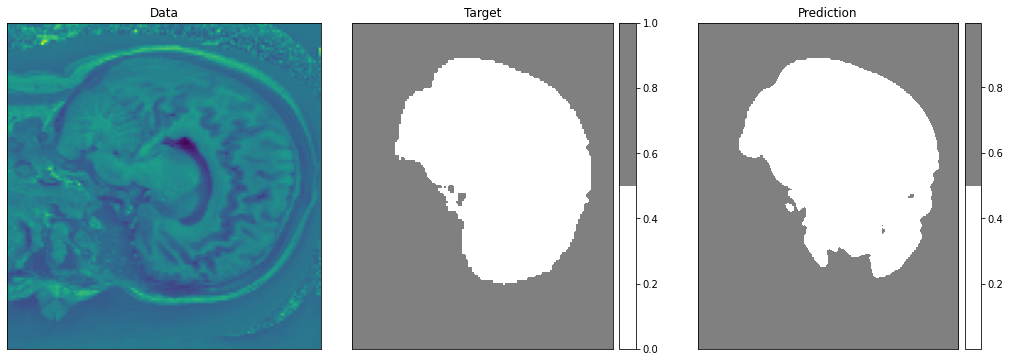

In [ ]:
from matplotlib.colors import ListedColormap
#unet 4, 6, 7 
data,target,prediction=predict(model,test_dataloader)
idx = 4
# Create a custom colormap with white and grey
custom_cmap = ListedColormap(['white', 'grey'])

# Create a 1x3 subplot grid, sharing the x and y axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Remove the ticks and tick labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Display the data image on the first subplot
im1 = axes[0].imshow(data[idx][0], aspect='auto')
axes[0].set_title('Data')

# Display the target image on the second subplot
im2 = axes[1].imshow(target[idx][0], cmap=custom_cmap, aspect='auto')
axes[1].set_title('Target')
fig.colorbar(im2, ax=axes[1], pad=0.02)

# Display the prediction image on the third subplot
im3 = axes[2].imshow(prediction[idx][0], cmap=custom_cmap, aspect='auto')
axes[2].set_title('Prediction')
fig.colorbar(im3, ax=axes[2], pad=0.02)

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.1)

# Display the plot
plt.show()

In [ ]:
import torch

def sum_pixels_per_class(one_hot_tensor):
    one_hot_tensor=torch.from_numpy(one_hot_tensor)

    # Ensure the input tensor has the correct shape
    assert one_hot_tensor.shape == (2, 128, 128), "The input tensor shape should be (2, 128, 128)"
    
    # Sum the pixels for each class along the height and width dimensions
    pixel_sums = torch.sum(one_hot_tensor, dim=(1, 2))
    
    print(f"Sum of pixels for Class 0: {pixel_sums[0]}")
    print(f"Sum of pixels for Class 1: {pixel_sums[1]}")
    return pixel_sums



def sum_pixels_per_class_batch(one_hot_batch_tensor):
    assert one_hot_batch_tensor.shape == (40, 2, 128, 128), "The input tensor shape should be (40, 2, 128, 128)"
    pixel_sums = torch.sum(one_hot_batch_tensor, dim=(0, 2, 3))
    return pixel_sums



In [ ]:
# data loader to load all testing data in sequence 
X_test =  torch.Tensor(X_IOP_centered[0:int(len(X_IOP_centered))])
y_test = torch.Tensor(y_IOP[0:int(len(y_IOP))])
X_test_slices = np.asarray(reslice(X_test,1))
y_test_slices = reslice(y_test,1).reshape((2840, 128, 128))
y_test_slices = to_one_hot_binary_matrix_batch(y_test_slices)
print(X_test_slices.shape)
print(y_test_slices.shape)

def calculate_vol(net, test_dataloader):
    dict_1_preds={}
    dict_0_preds={}
    dict_1_true={}
    dict_0_true={}
 
    class_1_volume_pred=0
    class_0_volume_pred=0
    class_1_volume_true=0
    class_0_volume_true=0


    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device).float()
          target = target.to(device).float()
          pred = net(data)
          class_1_volume_pred+=sum_pixels_per_class_batch(pred)[0]
          class_0_volume_pred+=sum_pixels_per_class_batch(pred)[1]
          class_1_volume_true+=sum_pixels_per_class_batch(target)[0]
          class_0_volume_true+=sum_pixels_per_class_batch(target)[1]
          dict_1_preds[batch_idx]=sum_pixels_per_class_batch(pred)[0].cpu().numpy()
          dict_0_preds[batch_idx]=sum_pixels_per_class_batch(pred)[1].cpu().numpy()
          dict_1_true[batch_idx]=sum_pixels_per_class_batch(target)[0].cpu().numpy()
          dict_0_true[batch_idx]=sum_pixels_per_class_batch(target)[1].cpu().numpy()

    return class_1_volume_pred.cpu().numpy(),class_0_volume_pred.cpu().numpy(),class_1_volume_true.cpu().numpy(), class_0_volume_true.cpu().numpy(), dict_1_preds, dict_1_true, dict_0_preds,dict_0_true

test_dataset = numpy_dataset(X_test_slices, y_test_slices)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=False, drop_last=False)

(2840, 1, 128, 128)
(2840, 2, 128, 128)


In [ ]:
# unet
class_1_volume_pred,class_0_volume_pred,class_1_volume_true, class_0_volume_true, dict_1_preds, dict_1_true, dict_0_preds,dict_0_true = calculate_vol(model,test_dataloader)
print("Brain volume")
print(class_1_volume_pred)
print(class_1_volume_true)
print("Other area volume")
print(class_0_volume_pred)
print(class_0_volume_true)
class_1_volume_true-class_1_volume_pred

# calculating statistics 
errors=[]
for k in dict_1_preds.keys():
  true_volume=dict_1_true[k]
  predicted_volume=dict_1_preds[k]
  delta=np.abs(true_volume-predicted_volume)
  error = delta/true_volume
  errors.append(error)

  #print(error)
print("Average error on test data")
print(np.mean(errors))
print("Average std on test data")
print(np.std(errors))
print((31120996.0-30721010.0)/2840)

In [ ]:
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SegNet(in_channels=1, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
start_time = time.time()
train_loss_history, train_dice_history, val_loss_history, val_dice_history,e = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)
end_time = time.time()

Epoch: 1/50 |  Train Loss: 0.400, Val Loss: 0.325, Train DICE: 0.900, Val DICE: 0.941
Best validation dice coefficient improved to 0.941
Epoch: 2/50 |  Train Loss: 0.089, Val Loss: 0.287, Train DICE: 0.978, Val DICE: 0.947
Best validation dice coefficient improved to 0.947
Epoch: 3/50 |  Train Loss: 0.070, Val Loss: 0.337, Train DICE: 0.982, Val DICE: 0.944
No improvement in validation dice coefficient for 1 consecutive epochs
Epoch: 4/50 |  Train Loss: 0.062, Val Loss: 0.250, Train DICE: 0.984, Val DICE: 0.955
Best validation dice coefficient improved to 0.955
Epoch: 5/50 |  Train Loss: 0.057, Val Loss: 0.272, Train DICE: 0.986, Val DICE: 0.953
No improvement in validation dice coefficient for 1 consecutive epochs
Epoch: 6/50 |  Train Loss: 0.053, Val Loss: 0.277, Train DICE: 0.987, Val DICE: 0.952
No improvement in validation dice coefficient for 2 consecutive epochs
Epoch: 7/50 |  Train Loss: 0.050, Val Loss: 0.247, Train DICE: 0.987, Val DICE: 0.959
Best validation dice coefficient

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/dhl_exam/models/segnet_model_brain.pth')

In [ ]:
dict_layer_to_parameters={}
layer_train_loss_history={}
layer_train_dice_history={}
layer_val_loss_history={}
layer_val_dice_history={}
dict_pred_dice={}
dict_stopping_epoch={}
dict_time_taken={}
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
layers=[5]

for layer in layers:
  start_time = time.time()
  model = UNet(n_channels=1, n_classes=2, bilinear=False).to(device)
  print("Number of layers: ", layer)
  print("Number of parameters: ", count_parameters(model))
  dict_layer_to_parameters[layer]=count_parameters(model)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
  train_loss_history, train_dice_history, val_loss_history, val_dice_history,se = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)
  end_time = time.time()
  layer_train_loss_history[layer]=train_loss_history
  layer_train_dice_history[layer]=train_dice_history
  layer_val_loss_history[layer]=val_loss_history
  layer_val_dice_history[layer]=val_dice_history
  dict_pred_dice[layer]=prediction_dice(model, test_dataloader)
  dict_stopping_epoch[layer]=se
  dict_time_taken[layer]=end_time - start_time

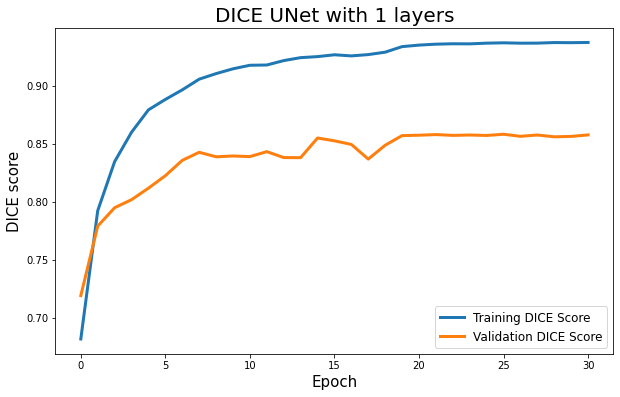

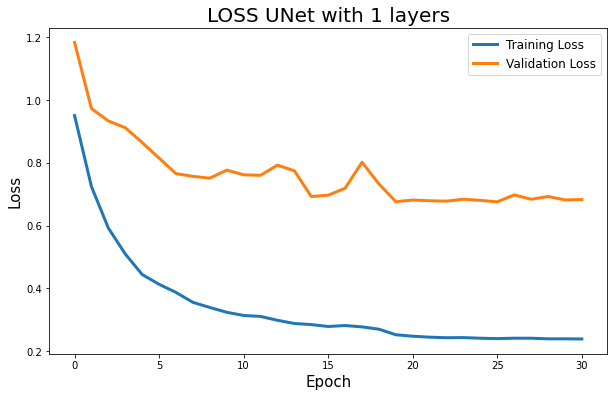

In [ ]:
for k in dict_layer_to_parameters.keys():

  plot_dice_history('DICE UNet with {} layers'.format(1), layer_train_dice_history[k], layer_val_dice_history[k], len(layer_val_dice_history[k]))
  plot_loss_history('LOSS UNet with {} layers'.format(1), layer_train_loss_history[k], layer_val_loss_history[k],len(layer_val_loss_history[k]))

In [ ]:
print(dict_layer_to_parameters)
print(dict_pred_dice)
print(dict_stopping_epoch)
print(dict_time_taken)

{5: 403714}
{5: 0.8189081769976487}
{5: 31}
{5: 91.0587911605835}


**BENCHMARK**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(input_shape=(1, 128, 128), num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 50

In [ ]:
%%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)

Epoch: 1/50 |  Train Loss: 1.069, Val Loss: 1.327, Train DICE: 0.637, Val DICE: 0.707
Epoch: 2/50 |  Train Loss: 1.000, Val Loss: 1.312, Train DICE: 0.700, Val DICE: 0.692
Epoch: 3/50 |  Train Loss: 0.945, Val Loss: 1.244, Train DICE: 0.714, Val DICE: 0.714
Epoch: 4/50 |  Train Loss: 0.870, Val Loss: 1.098, Train DICE: 0.737, Val DICE: 0.745
Epoch: 5/50 |  Train Loss: 0.801, Val Loss: 1.112, Train DICE: 0.757, Val DICE: 0.746
Epoch: 6/50 |  Train Loss: 0.732, Val Loss: 1.000, Train DICE: 0.780, Val DICE: 0.771
Epoch: 7/50 |  Train Loss: 0.660, Val Loss: 0.949, Train DICE: 0.808, Val DICE: 0.784
Epoch: 8/50 |  Train Loss: 0.604, Val Loss: 0.926, Train DICE: 0.827, Val DICE: 0.790
Epoch: 9/50 |  Train Loss: 0.558, Val Loss: 0.905, Train DICE: 0.842, Val DICE: 0.798
Epoch: 10/50 |  Train Loss: 0.526, Val Loss: 0.865, Train DICE: 0.852, Val DICE: 0.809
Epoch: 11/50 |  Train Loss: 0.482, Val Loss: 0.816, Train DICE: 0.865, Val DICE: 0.821
Epoch: 12/50 |  Train Loss: 0.466, Val Loss: 0.838, 

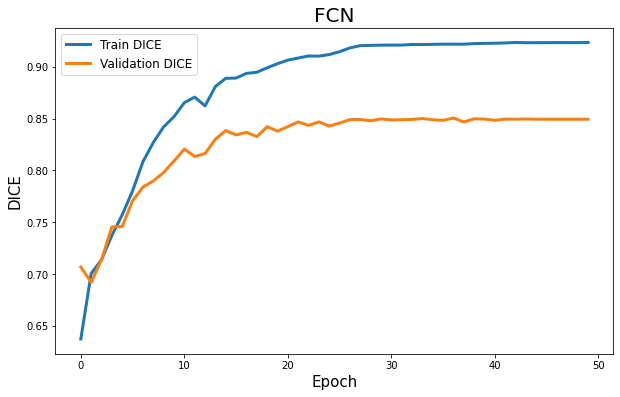

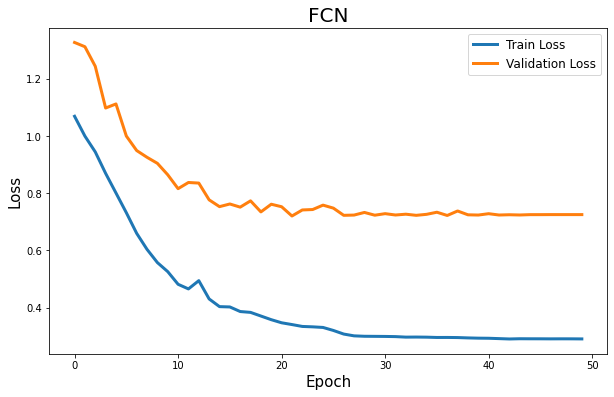

0.8010479018987675

In [ ]:
plot_dice_history('FCN', train_dice_history, val_dice_history, num_epochs)
plot_loss_history('FCN', train_loss_history, val_loss_history, num_epochs)
prediction_dice(model, test_dataloader)

In [ ]:
# training function with early stopping
def train_model_early_stopping(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs, patience=5):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    best_val_dice = 0
    consecutive_no_improvement = 0
    
    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func, optimizer)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func, scheduler)
        
        train_loss_history.append(train_mean_loss)
        train_dice_history.append(train_mean_dice)
        val_loss_history.append(val_mean_loss.cpu().numpy())
        val_dice_history.append(val_mean_dice)
        
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                 train_mean_loss,
                                                                                                                 val_mean_loss,
                                                                                                                 train_mean_dice,
                                                                                                                 val_mean_dice))
        
        # Check for improvement in validation dice coefficient
        if val_mean_dice > best_val_dice:
            best_val_dice = val_mean_dice
            consecutive_no_improvement = 0
            print('Best validation dice coefficient improved to {:.3f}'.format(best_val_dice))
        else:
            consecutive_no_improvement += 1
            print('No improvement in validation dice coefficient for {} consecutive epochs'.format(consecutive_no_improvement))
            if consecutive_no_improvement >= patience:
                print('Early stopping triggered after {} epochs'.format(epoch+1))
                break

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history,epoch+1


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(input_shape=(1, 128, 128), num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 50

In [ ]:
%%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)

Epoch: 1/50 |  Train Loss: 1.060, Val Loss: 1.326, Train DICE: 0.690, Val DICE: 0.697
Best validation dice coefficient improved to 0.697
Epoch: 2/50 |  Train Loss: 0.986, Val Loss: 1.281, Train DICE: 0.705, Val DICE: 0.712
Best validation dice coefficient improved to 0.712
Epoch: 3/50 |  Train Loss: 0.904, Val Loss: 1.180, Train DICE: 0.727, Val DICE: 0.729
Best validation dice coefficient improved to 0.729
Epoch: 4/50 |  Train Loss: 0.821, Val Loss: 1.088, Train DICE: 0.752, Val DICE: 0.750
Best validation dice coefficient improved to 0.750
Epoch: 5/50 |  Train Loss: 0.743, Val Loss: 0.997, Train DICE: 0.777, Val DICE: 0.768
Best validation dice coefficient improved to 0.768
Epoch: 6/50 |  Train Loss: 0.687, Val Loss: 0.944, Train DICE: 0.798, Val DICE: 0.785
Best validation dice coefficient improved to 0.785
Epoch: 7/50 |  Train Loss: 0.618, Val Loss: 0.948, Train DICE: 0.823, Val DICE: 0.789
Best validation dice coefficient improved to 0.789
Epoch: 8/50 |  Train Loss: 0.569, Val Los

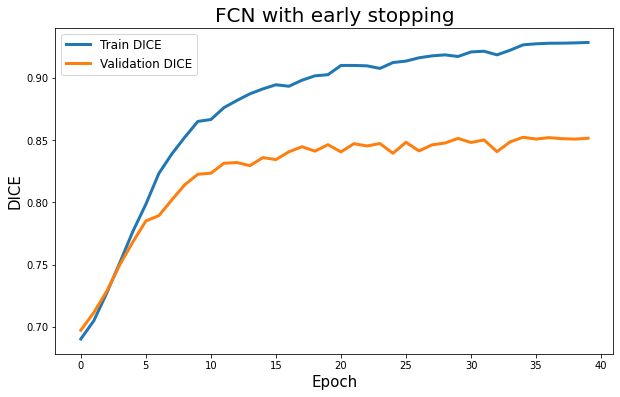

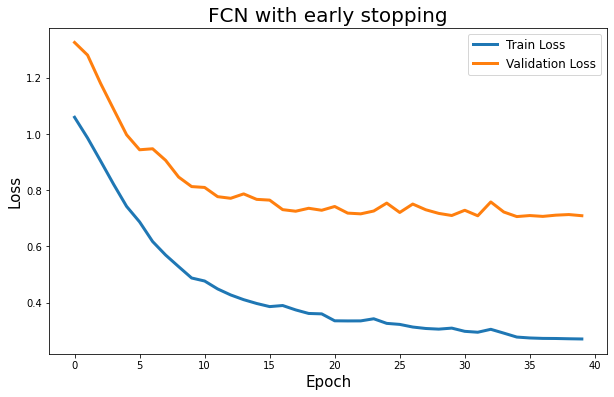

0.8018931013852304

In [ ]:
plot_dice_history('FCN with early stopping', train_dice_history, val_dice_history, 40)
plot_loss_history('FCN with early stopping', train_loss_history, val_loss_history, 40)
prediction_dice(model, test_dataloader)

In [ ]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
model = FCN_flexible(input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)


Epoch: 1/50 |  Train Loss: 1.073, Val Loss: 1.452, Train DICE: 0.675, Val DICE: 0.712
Best validation dice coefficient improved to 0.712
Epoch: 2/50 |  Train Loss: 1.014, Val Loss: 1.439, Train DICE: 0.690, Val DICE: 0.711
No improvement in validation dice coefficient for 1 consecutive epochs
Epoch: 3/50 |  Train Loss: 0.971, Val Loss: 1.348, Train DICE: 0.704, Val DICE: 0.732
Best validation dice coefficient improved to 0.732
Epoch: 4/50 |  Train Loss: 0.875, Val Loss: 1.210, Train DICE: 0.737, Val DICE: 0.752
Best validation dice coefficient improved to 0.752
Epoch: 5/50 |  Train Loss: 0.776, Val Loss: 1.094, Train DICE: 0.770, Val DICE: 0.784
Best validation dice coefficient improved to 0.784
Epoch: 6/50 |  Train Loss: 0.697, Val Loss: 0.994, Train DICE: 0.799, Val DICE: 0.800
Best validation dice coefficient improved to 0.800
Epoch: 7/50 |  Train Loss: 0.624, Val Loss: 0.905, Train DICE: 0.825, Val DICE: 0.812
Best validation dice coefficient improved to 0.812
Epoch: 8/50 |  Train 

In [ ]:
dict_layer_to_parameters={}
layer_train_loss_history={}
layer_train_dice_history={}
layer_val_loss_history={}
layer_val_dice_history={}
dict_pred_dice={}
dict_stopping_epoch={}
dict_time_taken={}
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
layers=[1,2,3,4,5,6,7]

for layer in layers:
  start_time = time.time()
  print("Number of layers: ", layer)
  print("Number of parameters: ", count_parameters(model))
  dict_layer_to_parameters[layer]=count_parameters(model)
  model = FCN_flexible(input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=layer).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
  train_loss_history, train_dice_history, val_loss_history, val_dice_history,se = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)
  end_time = time.time()
  layer_train_loss_history[layer]=train_loss_history
  layer_train_dice_history[layer]=train_dice_history
  layer_val_loss_history[layer]=val_loss_history
  layer_val_dice_history[layer]=val_dice_history
  dict_pred_dice[layer]=prediction_dice(model, test_dataloader)
  dict_stopping_epoch[layer]=se
  dict_time_taken[layer]=end_time - start_time


Number of layers:  1
Number of parameters:  501186
Epoch: 1/100 |  Train Loss: 1.078, Val Loss: 1.362, Train DICE: 0.684, Val DICE: 0.695
Best validation dice coefficient improved to 0.695
Epoch: 2/100 |  Train Loss: 1.024, Val Loss: 1.355, Train DICE: 0.692, Val DICE: 0.695
Best validation dice coefficient improved to 0.695
Epoch: 3/100 |  Train Loss: 1.007, Val Loss: 1.336, Train DICE: 0.693, Val DICE: 0.699
Best validation dice coefficient improved to 0.699
Epoch: 4/100 |  Train Loss: 0.987, Val Loss: 1.282, Train DICE: 0.699, Val DICE: 0.705
Best validation dice coefficient improved to 0.705
Epoch: 5/100 |  Train Loss: 0.966, Val Loss: 1.261, Train DICE: 0.705, Val DICE: 0.712
Best validation dice coefficient improved to 0.712
Epoch: 6/100 |  Train Loss: 0.944, Val Loss: 1.259, Train DICE: 0.713, Val DICE: 0.723
Best validation dice coefficient improved to 0.723
Epoch: 7/100 |  Train Loss: 0.923, Val Loss: 1.227, Train DICE: 0.721, Val DICE: 0.735
Best validation dice coefficient i

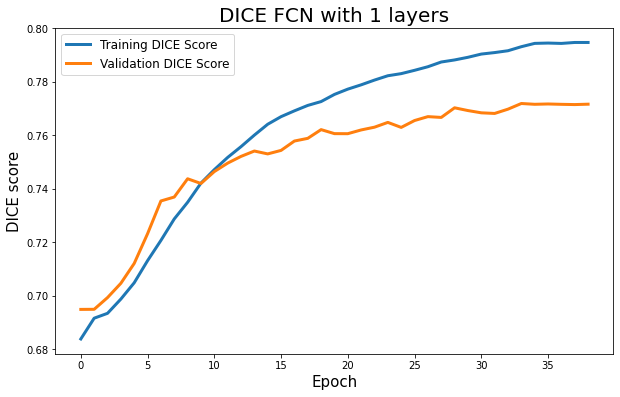

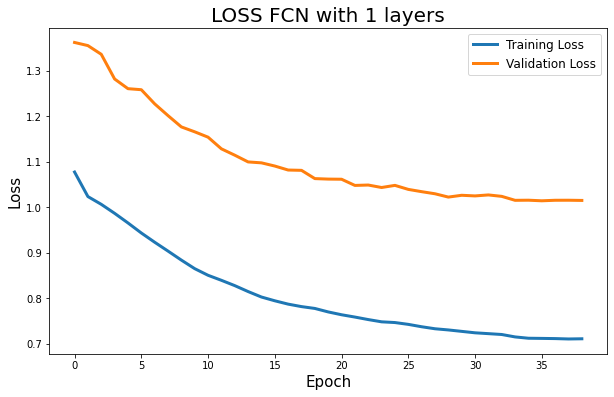

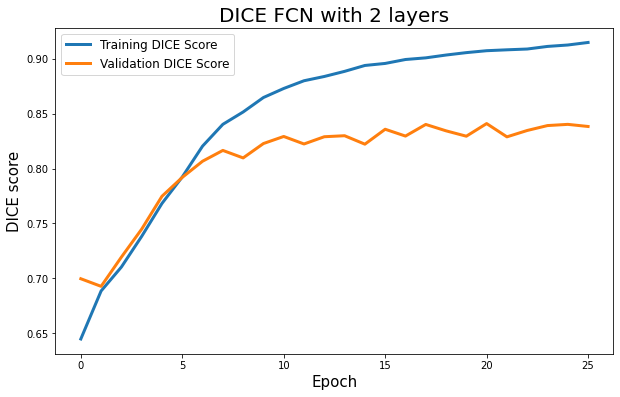

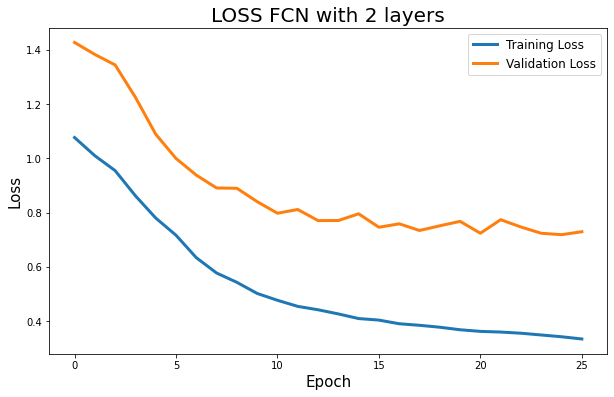

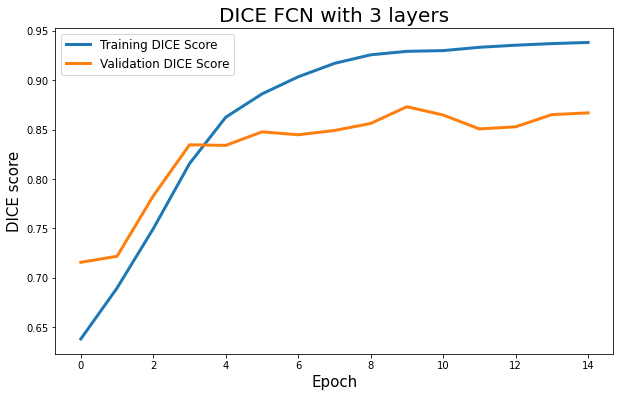

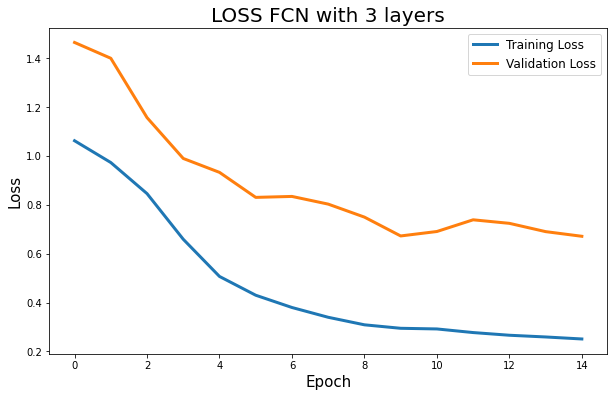

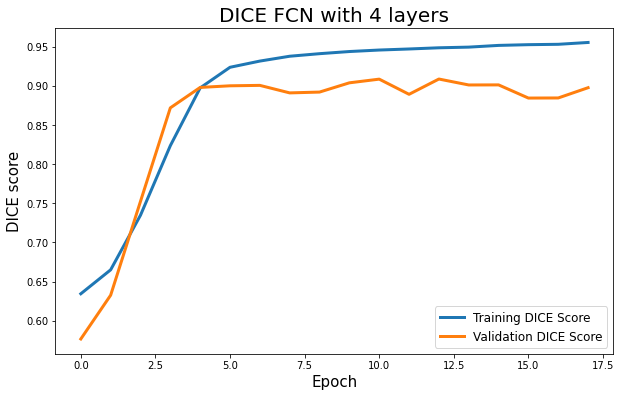

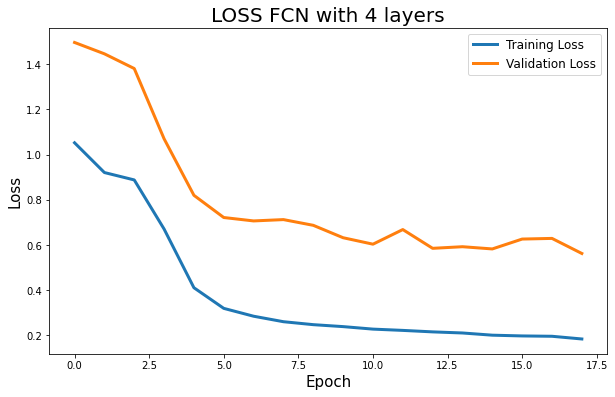

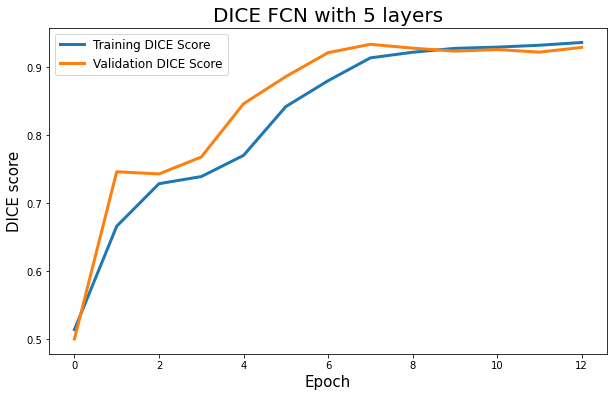

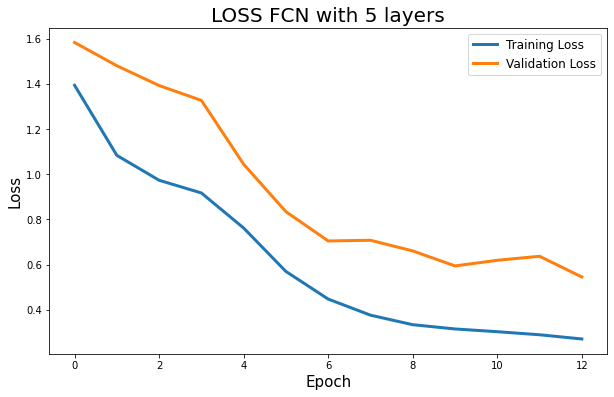

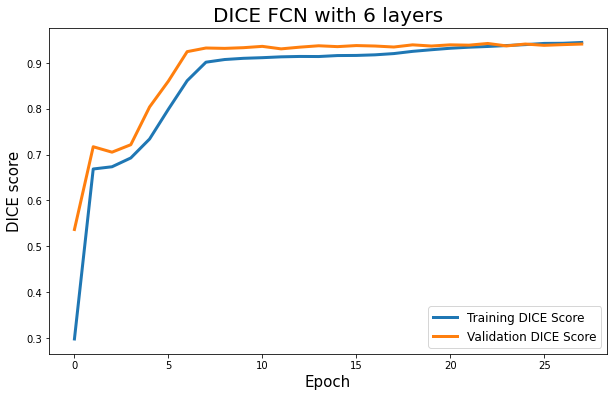

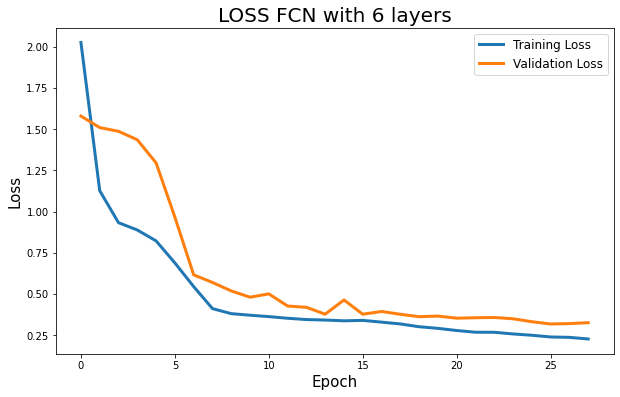

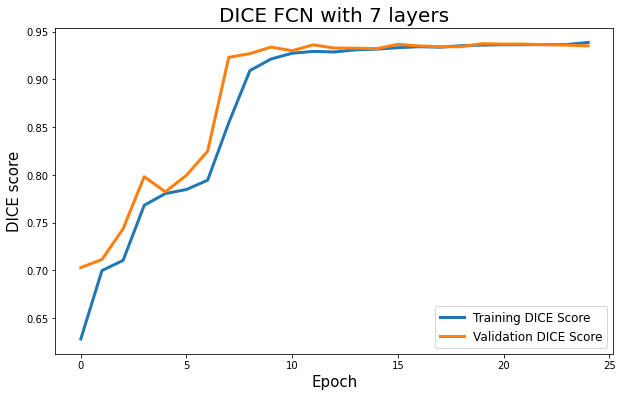

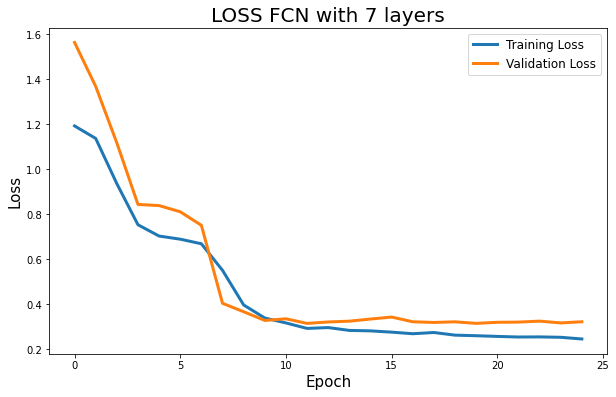

In [ ]:
for k in dict_layer_to_parameters.keys():

  plot_dice_history('DICE FCN with {} layers'.format(k), layer_train_dice_history[k], layer_val_dice_history[k], len(layer_val_dice_history[k]))
  plot_loss_history('LOSS FCN with {} layers'.format(k), layer_train_loss_history[k], layer_val_loss_history[k],len(layer_val_loss_history[k]))

**DROPOUT**

In [ ]:
d_train_loss_history={}
d_train_dice_history={}
d_val_loss_history={}
d_val_dice_history={}
dict_pred_dice={}
dict_stopping_epoch={}
dict_time_taken={}
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dropout_values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for d in dropout_values:
  start_time = time.time()
  print("Dropout value: ", d)
  print("Number of parameters: ", count_parameters(model))
  model = FCN_flexible(input_shape=(1, 128, 128), num_classes=2, dropout_prob=d, num_layers=4).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
  train_loss_history, train_dice_history, val_loss_history, val_dice_history,se = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)
  end_time = time.time()
  d_train_loss_history[d]=train_loss_history
  d_train_dice_history[d]=train_dice_history
  d_val_loss_history[d]=val_loss_history
  d_val_dice_history[d]=val_dice_history
  dict_pred_dice[d]=prediction_dice(model, test_dataloader)
  dict_stopping_epoch[d]=se
  dict_time_taken[d]=end_time - start_time


Dropout value:  0.1
Number of parameters:  548049474
Epoch: 1/100 |  Train Loss: 1.057, Val Loss: 1.290, Train DICE: 0.662, Val DICE: 0.683
Best validation dice coefficient improved to 0.683
Epoch: 2/100 |  Train Loss: 0.934, Val Loss: 1.126, Train DICE: 0.716, Val DICE: 0.755
Best validation dice coefficient improved to 0.755
Epoch: 3/100 |  Train Loss: 0.772, Val Loss: 0.983, Train DICE: 0.768, Val DICE: 0.782
Best validation dice coefficient improved to 0.782
Epoch: 4/100 |  Train Loss: 0.647, Val Loss: 0.689, Train DICE: 0.812, Val DICE: 0.863
Best validation dice coefficient improved to 0.863
Epoch: 5/100 |  Train Loss: 0.410, Val Loss: 0.489, Train DICE: 0.890, Val DICE: 0.913
Best validation dice coefficient improved to 0.913
Epoch: 6/100 |  Train Loss: 0.319, Val Loss: 0.462, Train DICE: 0.917, Val DICE: 0.917
Best validation dice coefficient improved to 0.917
Epoch: 7/100 |  Train Loss: 0.275, Val Loss: 0.371, Train DICE: 0.929, Val DICE: 0.928
Best validation dice coefficient

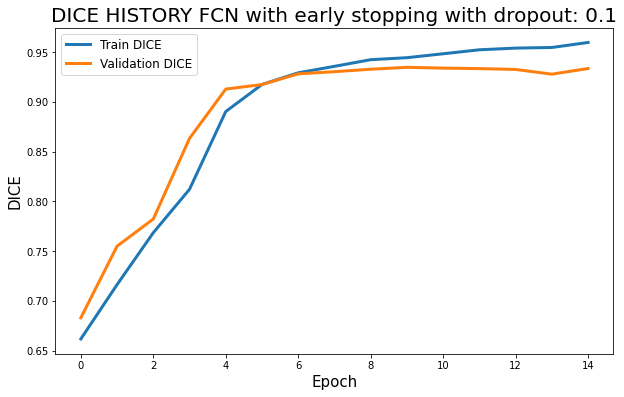

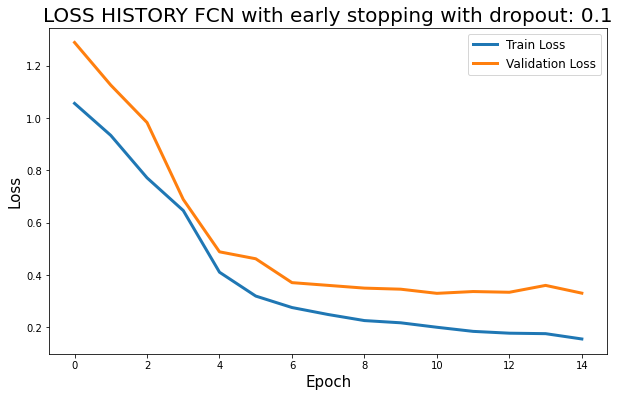

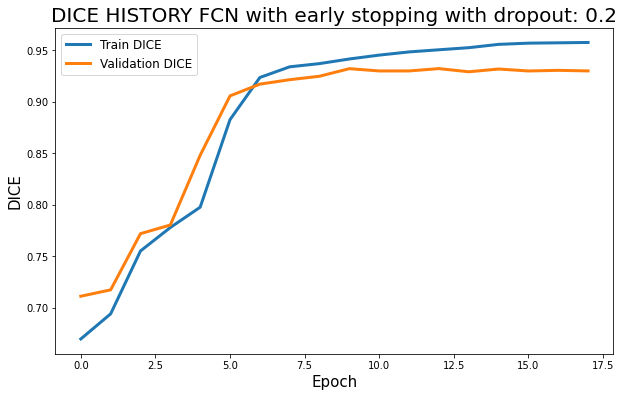

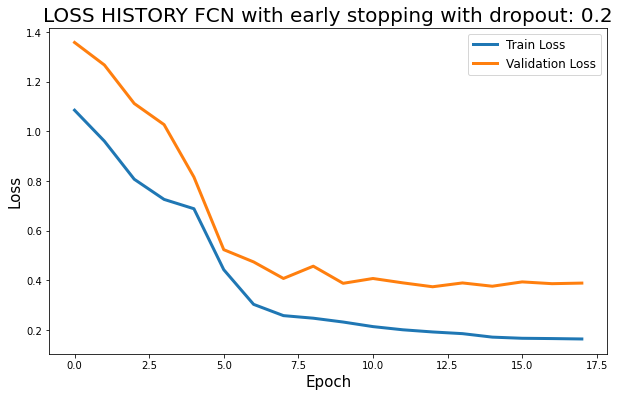

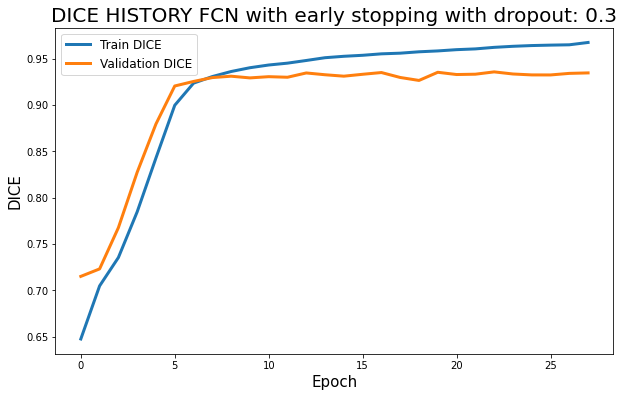

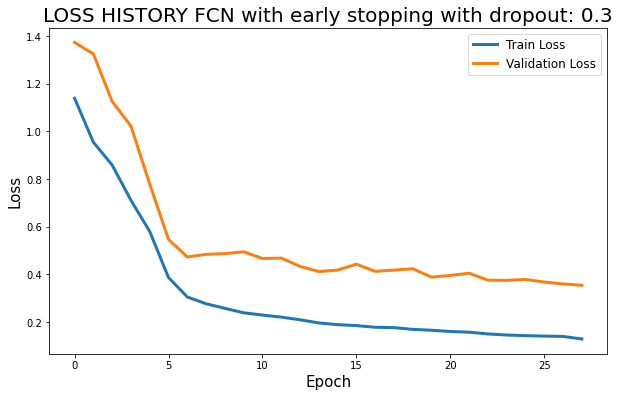

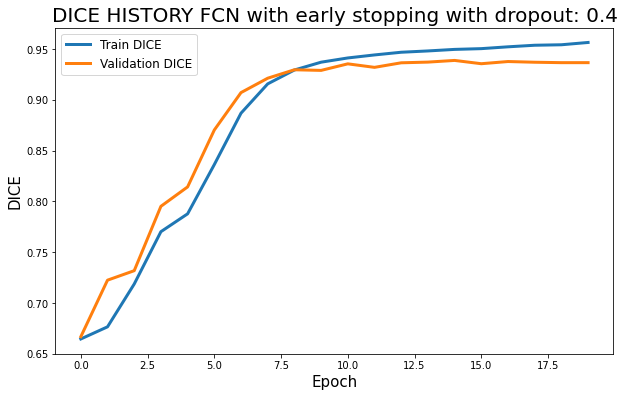

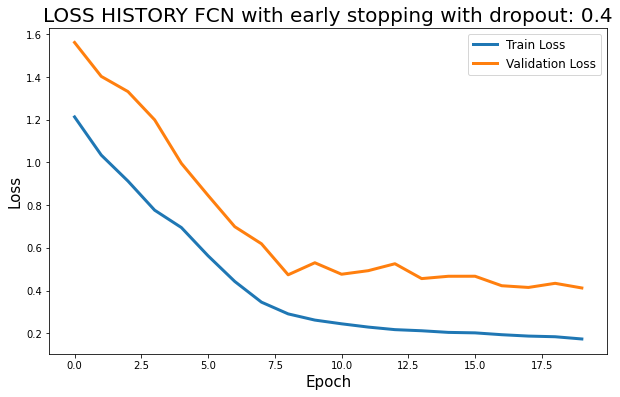

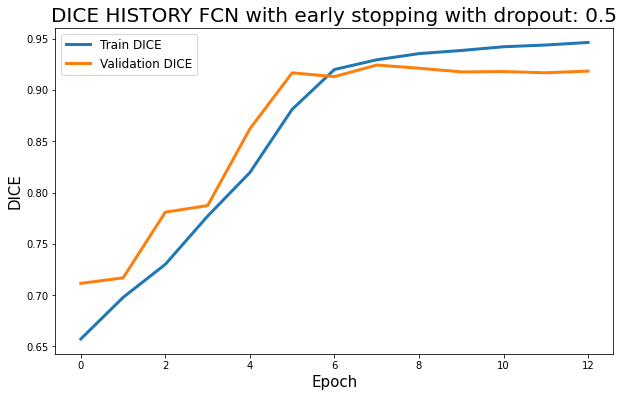

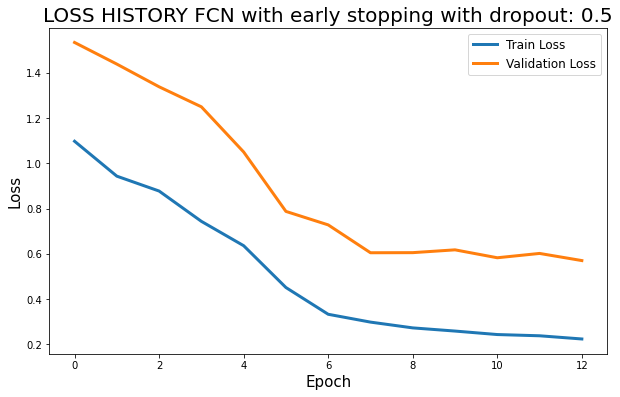

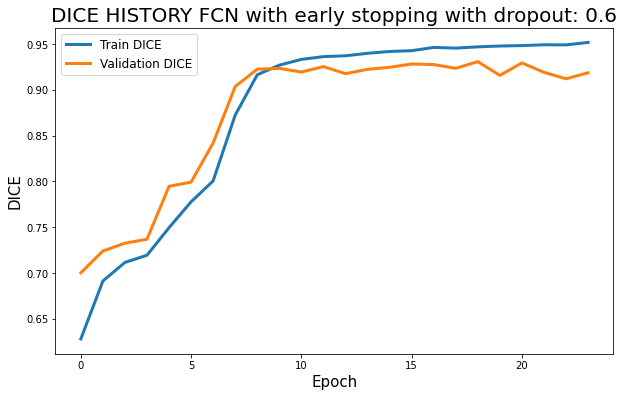

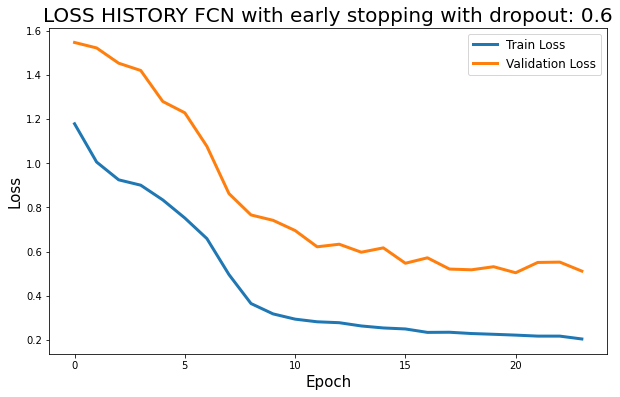

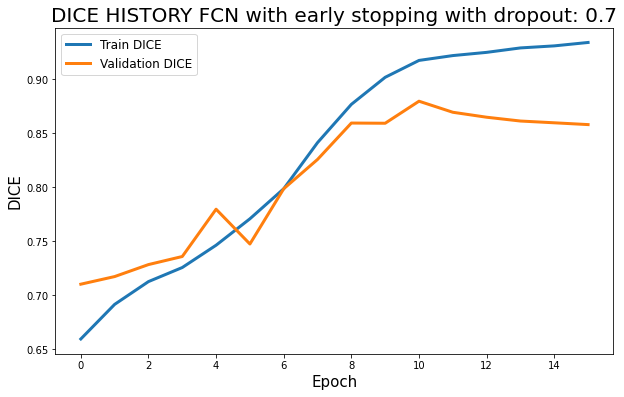

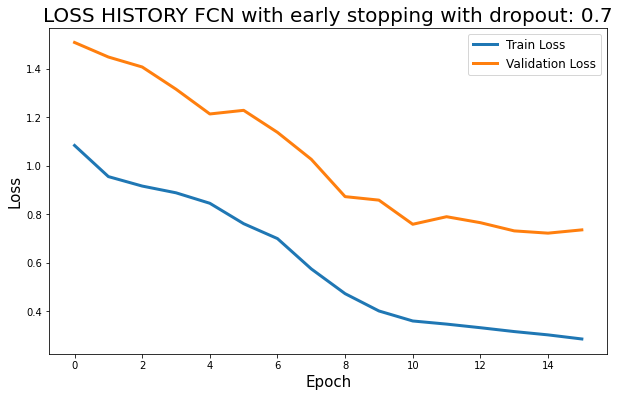

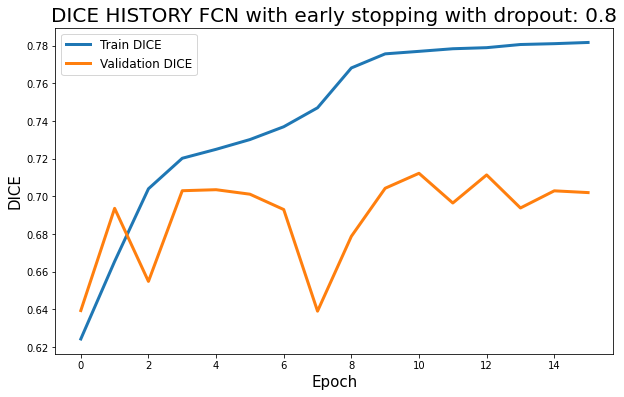

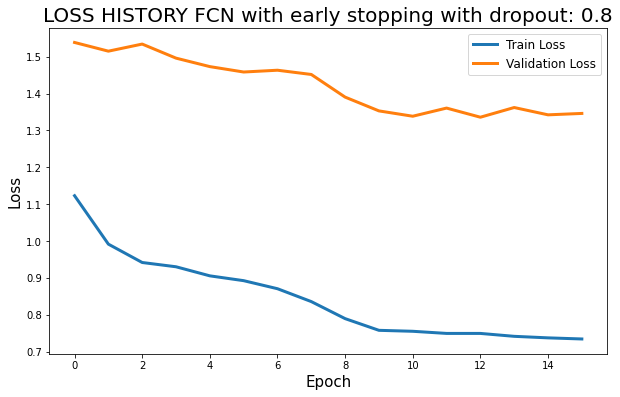

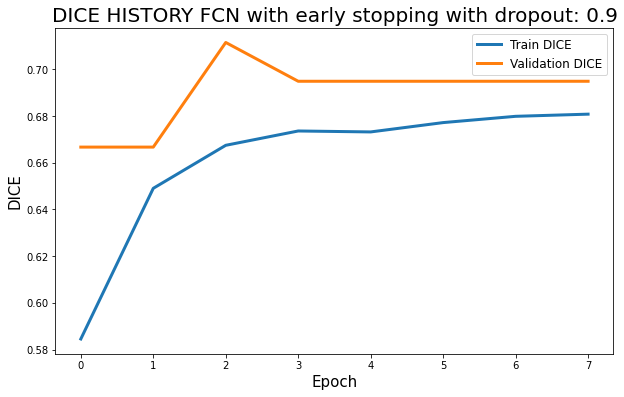

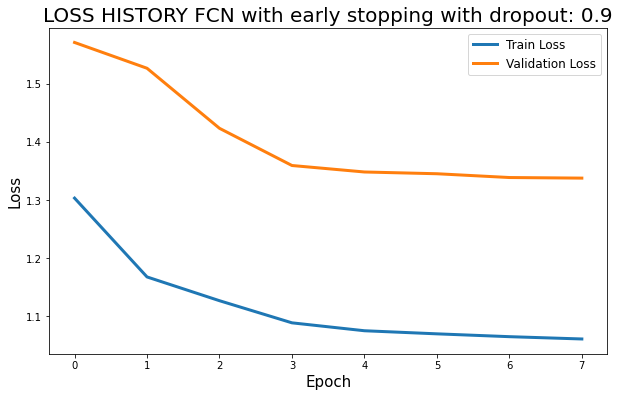

In [ ]:
for k in d_train_dice_history.keys():

  plot_dice_history('DICE HISTORY FCN with early stopping with dropout: '+str(k), d_train_dice_history[k], d_val_dice_history[k], len(d_val_dice_history[k]))
  plot_loss_history('LOSS HISTORY FCN with early stopping with dropout: '+str(k), d_train_loss_history[k], d_val_loss_history[k],len(d_val_loss_history[k]))

In [ ]:
d_train_loss_history={}
d_train_dice_history={}
d_val_loss_history={}
d_val_dice_history={}
dict_pred_dice={}
dict_stopping_epoch={}
dict_time_taken={}
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dropout_values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for d in dropout_values:
  start_time = time.time()
  print("Dropout value: ", d)
  print("Number of parameters: ", count_parameters(model))
  model = FCN_flexible(input_shape=(1, 128, 128), num_classes=2, dropout_prob=d, num_layers=2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
  train_loss_history, train_dice_history, val_loss_history, val_dice_history,se = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)
  end_time = time.time()
  d_train_loss_history[d]=train_loss_history
  d_train_dice_history[d]=train_dice_history
  d_val_loss_history[d]=val_loss_history
  d_val_dice_history[d]=val_dice_history
  dict_pred_dice[d]=prediction_dice(model, test_dataloader)
  dict_stopping_epoch[d]=se
  dict_time_taken[d]=end_time - start_time

Dropout value:  0.1
Number of parameters:  8532034
Epoch: 1/100 |  Train Loss: 1.077, Val Loss: 1.340, Train DICE: 0.631, Val DICE: 0.695
Best validation dice coefficient improved to 0.695
Epoch: 2/100 |  Train Loss: 1.016, Val Loss: 1.329, Train DICE: 0.694, Val DICE: 0.697
Best validation dice coefficient improved to 0.697
Epoch: 3/100 |  Train Loss: 0.985, Val Loss: 1.305, Train DICE: 0.699, Val DICE: 0.702
Best validation dice coefficient improved to 0.702
Epoch: 4/100 |  Train Loss: 0.923, Val Loss: 1.171, Train DICE: 0.719, Val DICE: 0.729
Best validation dice coefficient improved to 0.729
Epoch: 5/100 |  Train Loss: 0.838, Val Loss: 1.104, Train DICE: 0.746, Val DICE: 0.753
Best validation dice coefficient improved to 0.753
Epoch: 6/100 |  Train Loss: 0.760, Val Loss: 1.005, Train DICE: 0.770, Val DICE: 0.769
Best validation dice coefficient improved to 0.769
Epoch: 7/100 |  Train Loss: 0.690, Val Loss: 0.954, Train DICE: 0.797, Val DICE: 0.782
Best validation dice coefficient i

**Investigating different loss functions**

In [ ]:
lf_train_loss_history={}
lf_train_dice_history={}
lf_val_loss_history={}
lf_val_dice_history={}
dict_pred_dice={}
dict_stopping_epoch={}
dict_time_taken={}
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fns=[bce_dice_loss,]

for layer in layers:
  start_time = time.time()
  print("Number of layers: ", layer)
  print("Number of parameters: ", count_parameters(model))
  dict_layer_to_parameters[layer]=count_parameters(model)
  model = FCN_flexible(input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=layer).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
  train_loss_history, train_dice_history, val_loss_history, val_dice_history,se = train_model_early_stopping(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)
  end_time = time.time()
  layer_train_loss_history[layer]=train_loss_history
  layer_train_dice_history[layer]=train_dice_history
  layer_val_loss_history[layer]=val_loss_history
  layer_val_dice_history[layer]=val_dice_history
  dict_pred_dice[layer]=prediction_dice(model, test_dataloader)
  dict_stopping_epoch[layer]=se
  dict_time_taken[layer]=end_time - start_time